Fitting the R68 data with different yield models.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [3]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
g4=r68.load_G4()
cap=r68.load_simcap()

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
200000


In [4]:
#Energy binning
Emax = 2000 #eVee
Ebins=np.linspace(0,Emax,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)

R_meas = N_meas_PuBe/meas['PuBe']['tlive']-N_meas_Bkg/meas['Bkg']['tlive']
dR_meas = np.sqrt( N_meas_PuBe/(meas['PuBe']['tlive']**2) + N_meas_Bkg/(meas['Bkg']['tlive']**2) )

In [5]:
#Import yield models
import R68_yield as Yield
import R68_spec_tools as spec

dict_keys(['xx', 'yy', 'ex', 'ey'])


/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
Y=Yield.Yield('Lind',[0.15])
print(Y.models)

['Lind: Lindhard', 'Chav: Chavarria', 'Sor: Sorenson', 'Damic: Extrapolated Damic model']


In [7]:
#Main fitting functions which will be passed to minimizers

#Calculate a goodness of fit
#
#The analysis range [bin_low,bin_high)
def calcGOF(model='Lind', params=[0.15,1.2], bin_low=5, bin_high=101, GOF='chisq'):

    #Access the global data we loaded
    global R_meas, dR_meas, g4, cap
    
    #Define some local variables
    F_NR=None
    scale_g4=None
    scale_ng=None
    NR=None
    ER=None
    NG=None
    
    if model=='Lind':
        #Lindhard
        Y.model=model
        Y.pars=params[:1]
        F_NR=params[2]
        scale_g4=params[1]
        scale_ng=scale_g4

    elif (model=='Chav' or model=='Sor'):
        #Chavarria or Sorensen with constant
        Y.model=model
        Y.pars=params[:2]
        F_NR=params[3]
        scale_g4=params[2]
        scale_ng=scale_g4

    elif (model=='Damic'):
        #Damic yield 
        Y.model=model
        Y.pars=[]
        F_NR=params[1]
        scale_g4=params[0]
        scale_ng=scale_g4

    else:
        print('Error: Yield model not defined.')
        return None
    
    #Build the spectra
    #NR,ER,NG=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'], 
                                         #Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)

    NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                        Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)


    R_pred = NR/g4['NR']['tlive'] + ER/g4['ER']['tlive'] + NG/cap['tlive']

    if GOF=='chisq':
        return Chisq(R_meas, R_pred, dR_meas)[bin_low:bin_high]
    else:
        print('Error: Bad GOF')
        return None

#Chisq goodness of fit of meas to pred, given predicted uncertainties unc
def Chisq(meas, pred, unc):
    return ((meas-pred)**2)/(unc**2)

In [8]:
from scipy.optimize import minimize
import time

In [9]:
#Fit the Lindhard model

#Wrapper to calc the sum of the bin-wise fit residuals
def LindFit_helper(params):
    return np.sum(calcGOF(model='Lind', params=params, bin_low=5, bin_high=101, GOF='chisq'))

#Lindhard
x0=[0.2, 1.5, 2.4]  #k, sim_scale, F_NR
bounds=((0,1),(0,10),(0,5))

start = time.time()
resL = minimize( LindFit_helper, x0, bounds=bounds )
end = time.time()
print('{0:.1f} minutes'.format((end - start)/60.))

print(resL)

/data/chocula/mast/cdms/analysis/run068/R68_paper2019/analysis_notebooks/R68_spec_tools.py:333: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(sigma>0, 0.5*erf((mu-xlow)/np.sqrt(2*sigma**2)) - 0.5*erf((mu-xhi)/np.sqrt(2*sigma**2)), 1.0*((mu>xlow) & (mu<xhi)))


24.5 minutes
      fun: 116.99924063602617
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.17587496,  0.01571152,  0.00052438])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 128
      nit: 20
   status: 0
  success: True
        x: array([0.17622931, 1.55589391, 3.8462802 ])


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


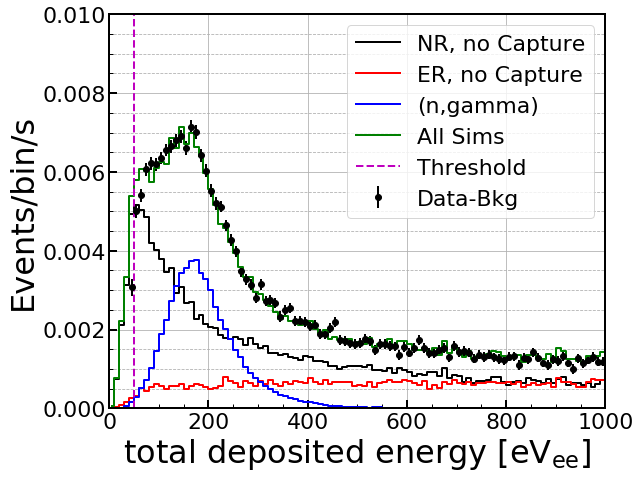

In [10]:
#Check the best fit results
Y.model='Lind'
#Lindhard
Y.pars=resL.x[:1]
F_NR=resL.x[2]
scale_g4=resL.x[1]
scale_ng=scale_g4

NR,ER,NG=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5])

In [11]:
#Chisq/DOF
print('Chisq/DOF:',LindFit_helper(resL.x)/(101-5-3))

Chisq/DOF: 1.2580563509250127


In [12]:
#Estimate parameter variances
#Inverse of hessian is unscaled covariance matrix (https://e-maxx.ru/bookz/files/numerical_recipes.pdf)
#Follow the perscription here to rescale it (https://stackoverflow.com/questions/43593592/errors-to-fit-parameters-of-scipy-optimize)

#TODO: Not sure whether this is meaningful or not.
ftol = 2.220446049250313e-09
resL.err=np.sqrt(max(1, abs(resL.fun))*ftol*np.diag(resL.hess_inv.todense()))

#Lindhard
par_names=["k","sim_scale","F_NR"]
for i,j,k in zip(par_names,resL.x,resL.err):
    print("{0} = {1:.3f} +/- {2:.4e}".format(i,j,k))

k = 0.176 +/- 1.3385e-05
sim_scale = 1.556 +/- 2.4325e-05
F_NR = 3.846 +/- 3.4266e-04


In [13]:
from scipy.optimize import fsolve
def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


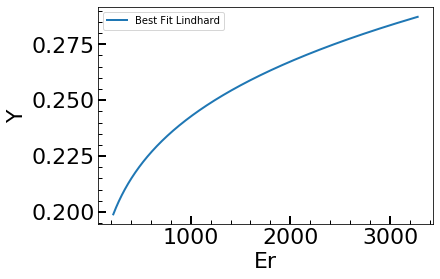

In [14]:
#Plot best fit yield
fig, ax = plt.subplots(1,1)

Y.model='Lind'
Y.pars=resL.x[:1]

Er_low_l=ERtoNR(Ebins[5],Y,V,eps)[0]
Er_high_l=ERtoNR(Ebins[101],Y,V,eps)[0]

E_l=np.linspace(Er_low_l,Er_high_l,1000)


Ymean_l=Y.calc(E_l)
Y.pars=resL.x[:1]+3*resL.err[:1]
Yup_l=Y.calc(E_l)
Y.pars=resL.x[:1]-3*resL.err[:1]
Ydown_l=Y.calc(E_l)

ax.plot(E_l, Ymean_l,label='Best Fit Lindhard')
ax.fill_between(E_l,Ydown_l,Yup_l,alpha=0.5)

#ax.axvline(Ebins[5]/Y.calc(Ebins[5]),color='k',linestyle='--',label="Noise Threshold")
#ax.axvline(Ebins[101]/Y.calc(Ebins[5]),color='r',linestyle='--',label="Upper Analysis Threshold")

ax.set_xlabel('Er')
ax.set_ylabel('Y')
#ax.set_ylim(0.1,0.4)

plt.legend()

In [15]:
#Chavarria fit

#Wrapper to calc the sum of the bin-wise fit residuals
def ChavFit_helper(params):
    return np.sum(calcGOF(model='Chav', params=params, bin_low=5, bin_high=101, GOF='chisq'))

x0=[0.18, 0.2, 1.5, 3]  #k, a, sim_scale, F_NR
bounds=((0,1),(1./1000,1./0.1),(0,10),(0,5))

%time resC = minimize( ChavFit_helper, x0, bounds=bounds )

print(resC)

/data/chocula/mast/cdms/analysis/run068/R68_paper2019/analysis_notebooks/R68_yield.py:66: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(1/(a*Er)+1/yLind(Er,k))


CPU times: user 8h 39min 30s, sys: 46min 14s, total: 9h 25min 44s
Wall time: 2h 23min 21s
      fun: 111.60577948210377
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00010658, -0.00036238, -0.00138272,  0.01740545])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 605
      nit: 41
   status: 2
  success: False
        x: array([0.18653817, 0.01071851, 1.58138323, 3.99112419])


In [16]:
#Chisq/DOF
print('Chisq/DOF:',ChavFit_helper(resC.x)/(101-5-4))

resC.err=np.sqrt(max(1, abs(resC.fun))*ftol*np.diag(resC.hess_inv.todense()))

#Chavarria
par_names=["k", "a", "sim_scale", "F_NR"]
for i,j,k in zip(par_names,resC.x,resC.err):
    print("{0} = {1:.3f} +/- {2:.4e}".format(i,j,k))

Chisq/DOF: 1.21310629871852
k = 0.187 +/- 4.9781e-04
a = 0.011 +/- 4.9781e-04
sim_scale = 1.581 +/- 4.9781e-04
F_NR = 3.991 +/- 4.9781e-04


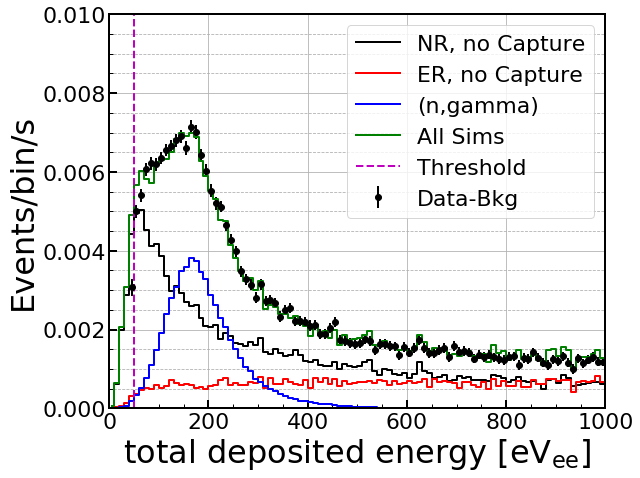

In [17]:
#Check the best fit results
Y.model='Chav'

Y.pars=resC.x[:2]
F_NR=resC.x[3]
scale_g4=resC.x[2]
scale_ng=scale_g4

NR_c,ER_c,NG_c=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)

spec.plotSpectra(E_bins=Ebins, N_nr=NR_c/g4['NR']['tlive'], N_er=ER_c/g4['ER']['tlive'], 
                 N_ng=NG_c/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5])

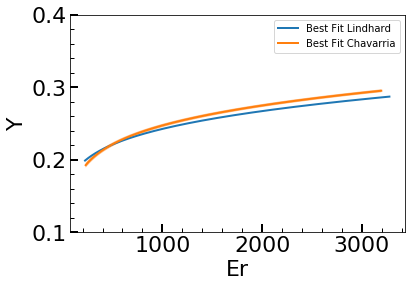

In [18]:
#Plot best fit yield
fig, ax = plt.subplots(1,1)

Y.model='Chav'
Y.pars=resC.x[:2]

Er_low_c=ERtoNR(Ebins[5],Y,V,eps)[0]
Er_high_c=ERtoNR(Ebins[101],Y,V,eps)[0]


E_c=np.linspace(Er_low_c,Er_high_c,1000)

Ymean_c=Y.calc(E_c)
Y.pars=resC.x[:2]+3*resC.err[:2]
Yup_c=Y.calc(E_c)
Y.pars=resC.x[:2]-3*resC.err[:2]
Ydown_c=Y.calc(E_c)

ax.plot(E_l, Ymean_l,label='Best Fit Lindhard')
ax.fill_between(E_l,Ydown_l,Yup_l,alpha=0.5)

ax.plot(E_c, Ymean_c,label='Best Fit Chavarria')
ax.fill_between(E_c,Ydown_c,Yup_c,alpha=0.5)


ax.set_xlabel('Er')
ax.set_ylabel('Y')

ax.set_ylim(0.1,0.4)

plt.legend()

In [19]:
#Sorensen

#Wrapper to calc the sum of the bin-wise fit residuals
def SorFit_helper(params):
    return np.sum(calcGOF(model='Sor', params=params, bin_low=5, bin_high=101, GOF='chisq'))

x0=[0.15, 1e-4, 1.2, 2.4]  #k, q, sim_scale, F_NR
bounds=((0,1),(0,1e-3),(0,10),(0,5))

%time resS = minimize( SorFit_helper, x0, bounds=bounds )

print(resS)

/data/chocula/mast/cdms/analysis/run068/R68_paper2019/analysis_notebooks/R68_yield.py:74: RuntimeWarning: divide by zero encountered in true_divide
  y=yLind(Er,k)-q/eps
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/analysis_notebooks/R68_yield.py:74: RuntimeWarning: invalid value encountered in true_divide
  y=yLind(Er,k)-q/eps


CPU times: user 6h 6min 19s, sys: 29min 22s, total: 6h 35min 42s
Wall time: 2h 10min 56s
      fun: 109.48895545285119
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.29494662e-02, -9.15257061e+00, -9.81543735e-03,  2.17426077e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 350
      nit: 59
   status: 0
  success: True
        x: array([1.81375414e-01, 6.53126632e-05, 1.57978414e+00, 4.10149738e+00])


In [20]:
#Chisq/DOF
print('Chisq/DOF:',SorFit_helper(resS.x)/(101-5-4))

#TODO: Not sure whether this is meaningful or not.
ftol = 2.220446049250313e-09
resS.err=np.sqrt(max(1, abs(resS.fun))*ftol*np.diag(resS.hess_inv.todense()))

#Sorensen
par_names=["k", "q", "sim_scale", "F_NR"]
for i,j,k in zip(par_names,resS.x,resS.err):
    print("{0} = {1:.3f} +/- {2:.4e}".format(i,j,k))

Chisq/DOF: 1.1900973418788172
k = 0.181 +/- 5.9787e-03
q = 0.000 +/- 1.8456e-04
sim_scale = 1.580 +/- 1.0360e-01
F_NR = 4.101 +/- 9.2340e-01


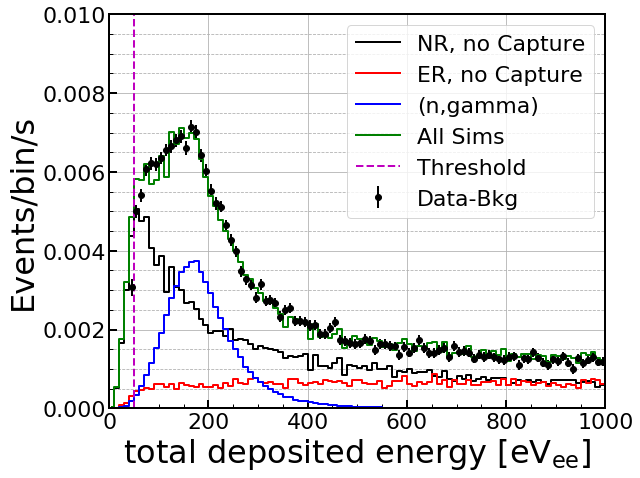

In [21]:
#Check the best fit results
Y.model='Sor'

Y.pars=resS.x[:2]
F_NR=resS.x[3]
scale_g4=resS.x[2]
scale_ng=scale_g4

NR_s,ER_s,NG_s=spec.buildSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, seed=1)

spec.plotSpectra(E_bins=Ebins, N_nr=NR_s/g4['NR']['tlive'], N_er=ER_s/g4['ER']['tlive'], 
                 N_ng=NG_s/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5])

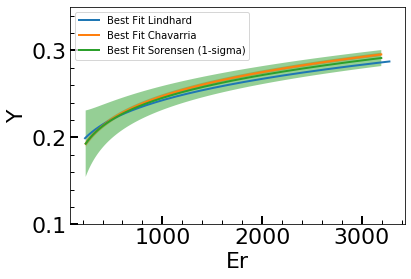

In [26]:
#Plot best fit yields
fig, ax = plt.subplots(1,1)

Y.model='Sor'
Y.pars=resS.x[:2]

Er_low_s=ERtoNR(Ebins[5],Y,V,eps)[0]
Er_high_s=ERtoNR(Ebins[101],Y,V,eps)[0]

E_s=np.linspace(Er_low_c,Er_high_c,1000)

Ymean_s=Y.calc(E_s)
Y.pars=resS.x[:2]+1*resS.err[:2]*np.array([1,-1])
Yup_s=Y.calc(E_s)
Y.pars=resS.x[:2]+1*resS.err[:2]*np.array([-1,1])
Ydown_s=Y.calc(E_s)

ax.plot(E_l, Ymean_l,label='Best Fit Lindhard')
ax.fill_between(E_l,Ydown_l,Yup_l,alpha=0.5)

ax.plot(E_c, Ymean_c,label='Best Fit Chavarria')
ax.fill_between(E_c,Ydown_c,Yup_c,alpha=0.5)

ax.plot(E_s, Ymean_s,label='Best Fit Sorensen (1-sigma)')
ax.fill_between(E_s,Ydown_s,Yup_s,alpha=0.5)

ax.set_xlabel('Er')
ax.set_ylabel('Y')
ax.set_ylim(0.1,0.35)

plt.legend()

In [23]:
#Save this work
import pickle as pkl
import os

saveFits=True

if saveFits:
    ifile = 0
    fname='data/fit_chisq_v{0}.pkl'.format(ifile+1)
    while os.path.exists(fname):
        ifile += 1
        fname='data/fit_chisq_v{0}.pkl'.format(ifile+1)
        
    print(fname)
    saveFile = open(fname, 'wb')
    pkl.dump(resL,saveFile)
    pkl.dump(resC,saveFile)
    pkl.dump(resS,saveFile)
    saveFile.close()

data/fit_chisq_v1.pkl
